In [1]:
import numpy as np
import math 

from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, CustomJS, Button
from bokeh.plotting import figure, show

In [2]:
# Scatterplot: x from uniform(0,1); y from normal(0,1)
# Add 1 particle on click
# Send 100 particles at once
# Reset the screen
# Continuous stream of particles + jde vypnout
# User-defined distribution function

from bokeh.models import CustomJS, ColumnDataSource
from bokeh.plotting import figure, output_file, show

source = ColumnDataSource(data=dict(x=[], y=[])) # z=x_pdf, w=y_pdf
max_x = 10   # Délka stínítka

# Screen with points
p = figure(
    title="Screen of the Young double slit experiment",
    tools="pan,wheel_zoom,box_zoom,reset",         # (de)activate tools    
    sizing_mode="stretch_width", 
#    max_width=1000, 
    width=500,
    height=500,
    x_axis_label="x",
    y_axis_label="y",
    x_range=(0,max_x),
    y_range=(0, 1),
)
p.circle('x', 'y', source=source, size=10, fill_color="red")

# Probability denstity function above the screen
pd = figure(title="Probability denstity function of Young double slit experiment",
            sizing_mode="stretch_width", 
            width=p.width, height=250, x_range=p.x_range)
#pd.line('x', 'y', source=source, color="navy", alpha=0.5)
# pd.line('x_pdf', 'y_pdf', source=source, line_width=3, line_alpha=0.6, line_color='navy')

# Theoretical probability density function -- young double slit
# amp = 1  # ------------> jak předávat hodnoty těchto konstant do js funkce youngPDF(x)?
# freq = 1
# x = np.linspace(0, max_x, 100)
# young_pdf = amp*np.cos(freq*x)**2
# pd.line(x, young_pdf, line_width=2, line_color="navy", legend_label="Probability Density Function")

# Histogram -- young double slit
rng = np.random.default_rng()            #-----------------> nagenerovat vzorky z dat ze stínítka, ne z norm. rozd.
x = rng.normal(loc=5, scale=1, size=1000)

bins = np.linspace(0, max_x, 50)
hist, edges = np.histogram(x, density=True, bins=bins)
pd.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white",
         legend_label="1000 random samples")

# Probability density function
amp = 1  # ------------> jak předávat hodnoty těchto konstant do js funkce youngPDF(x)?
freq = 1
x = np.linspace(0, max_x, 100)
young_pdf = amp*np.cos(freq*x)**2
pd.line(x, young_pdf, line_width=2, line_color="navy", legend_label="Probability Density Function")

# Buttons ----------------------------------------------------------------------
# Add 1 particle
button = Button(label="Add 1 particle", button_type="success")

# Send 100 particles at once
button100 = Button(label="Send 100 particles", button_type="success")

# Reset the screen
resetbutton = Button(label="Reset", button_type="success")

# Continuous stream of particles
streamtoggle = Button(label="Send continuous stream", button_type="success")
# -----------------------------------------------------------------------------
# JS CALLBACKS

# Def function of normal distribution
jscode_normalPDF = """
    function randn() {
      let u = 0, v = 0;
      
      while(u === 0) u = Math.random(); //Converting [0,1) to (0,1)
      while(v === 0) v = Math.random();
      
      let num = Math.sqrt( -2.0 * Math.log( u ) ) * Math.cos( 2.0 * Math.PI * v );
      num = num / 10.0 + 0.5;           // Translate to 0 -> 1
      
      if (num > 1 || num < 0) return randn_bm() // resample between 0 and 1
      return num
      }
 """

# Def function of Young double slit interference distribution
jscode_youngPDF = """
    function youngPDF(x) { // PDF of Young interferention
      const amp = 1;
      const freq = 1;
      return amp*Math.cos(freq*x)**2
    }
    
    let minI = 0;
    let N = 100;
    
    function youngCDF(maxI) { // CDF of Young interferention
      let integral = 0;
      let delta = (maxI - minI)/N
      for (let i = 0; i < N; i++) {
          integral += youngPDF(delta/2 + i*delta)*delta;
      } 
      return integral
    }

    const sample = [];
    for (let i = 0; i < max_x; i += 0.01) {
      sample.push(i);
    }
    const sample_y = sample.map(youngCDF);
    
    // Normalization of PDF to the length of shade (max_x)
    const h = sample_y[sample_y.length-1] - sample_y[0];

    let index;
    function youngInverseCDF(t) { // inverse CDF of Young interferention
        for (let i = 0; i < sample_y.length; i++) {
            if (sample_y[i] > t) {
            index = i;
            break;
            }
        }
        const x2 = sample[index];
        const x1 = sample[index - 1];
        const y1 = sample_y[index - 1]
        const c = (x2 - x1)/(sample_y[index] + y1);
        return c*t - c*y1 + x1;
    }
"""
    
callback = CustomJS(args=dict(source=source, max_x=max_x), code=jscode_normalPDF + jscode_youngPDF +"""
    
    source.data.x.push(youngInverseCDF(h*Math.random()))
    source.data.y.push(Math.random())

    // update the data source with local changes
    source.change.emit()
    """)

callback2 = CustomJS(args=dict(source=source, max_x=max_x), code=jscode_normalPDF + jscode_youngPDF +"""
    
    let i = 0;
    for (let i = 0; i < 100; i++) {
        source.data.x.push(youngInverseCDF(h*Math.random()))
        source.data.y.push(Math.random()) 
    }
    
    // update the data source with local changes
    source.change.emit()
    """)

callback_reset = CustomJS(args=dict(source=source), code="""
    
    source.data.x = []
    source.data.y = []
    source.change.emit()
    """)

callback_stream = CustomJS(args=dict(source=source, streamtoggle=streamtoggle, max_x=max_x), code=jscode_normalPDF + jscode_youngPDF +"""

    function sendparticle() {
        source.data.x.push(youngInverseCDF(h*Math.random()));
        source.data.y.push(Math.random());
        source.change.emit();
    }
    
    if (streamtoggle.button_type == "success") {
        const interval = setInterval(sendparticle, 300);
        sendparticle();
        source.interval = interval;
        streamtoggle.button_type = "danger";
        streamtoggle.label = "Stop stream";
        
    } else {
        clearInterval(source.interval);
        streamtoggle.button_type = "success";
        streamtoggle.label = "Send continuous stream";
    }
""")
# -------------------------------------------------------------------------------
# Callbacks to objects

button.js_on_event('button_click', callback)
button100.js_on_event('button_click', callback2)
resetbutton.js_on_event('button_click', callback_reset)
streamtoggle.js_on_event('button_click', callback_stream)

#buttons_layout = column(button, button100, resetbutton)
#show(row(p, buttons_layout))
show(row(column(pd, p), column(button, button100, resetbutton, streamtoggle)))

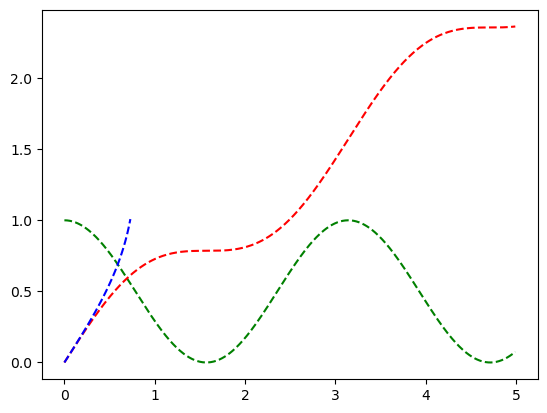

In [35]:
# Generating random variables from a probability distribution given by a PDF:
# CDF = integral of PDF
# inverse CDF gives the variables from a desired distribution

import matplotlib.pyplot as plt

# Defining a custom PDF
def youngPDF(x):
    amp = 1
    freq = 1
    return amp*math.cos(freq*x)**2

# Setting an interval and accuracy
minI = 0
N = 100

# Calculating CDF
def youngCDF(maxI):
    integral = 0
    delta = (maxI - minI)/N
    for i in range(N):
        integral += youngPDF(delta/2 + i*delta)*delta
    return integral

# Calculating an inverse function to CDF
sample = np.arange(0., 1., 0.01)
sample_y = [youngCDF(s) for s in sample]
def youngInverseCDF(y): 
    for i, y2 in enumerate(sample_y):
        if y2 > y :
            break
    x2 = sample[i]
    x1 = sample[i-1]
    y1 = sample_y[i-1]
    
    c = (x2-x1)/(y2 - y1)
    return c*y - c*y1 + x1

t = np.arange(0., 5, 0.01)
u = np.arange(sample_y[0], sample_y[-1]+0.01, 0.01)
p = plt.plot(t, [youngPDF(s) for s in t], 'g--', t, [youngCDF(s) for s in t], 'r--', u, [youngInverseCDF(s) for s in u], 'b--')
plt.show()

In [20]:
# Histogram in Bokeh
import numpy as np

from bokeh.plotting import figure, show

rng = np.random.default_rng()
x = rng.normal(loc=0, scale=1, size=1000)

plot = figure(width=670, height=400, toolbar_location=None,
           title="Normal (Gaussian) Distribution")

# Histogram
bins = np.linspace(-3, 3, 40)
hist, edges = np.histogram(x, density=False, bins=bins)
plot.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white",
         legend_label="1000 random samples")

# Probability density function
x = np.linspace(-3.0, 3.0, 100)
pdf = np.exp(-0.5*x**2) / np.sqrt(2.0*np.pi)
plot.line(x, pdf, line_width=2, line_color="navy", legend_label="Probability Density Function")

plot.y_range.start = 0
plot.xaxis.axis_label = "x"
plot.yaxis.axis_label = "PDF(x)"

show(plot)

In [3]:
# Generate linked scatterplot + histogram + TABLE displaying data + save button to export cvs of selected data

from random import random
import numpy as np

from bokeh.io import show

from bokeh.layouts import row
from bokeh.layouts import grid
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.models import Button  # for saving data
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn, Div
from bokeh.models import HoverTool
from bokeh.plotting import figure


# create data
x = [random() for x in range(500)]
y = [random() for y in range(500)]

# create first subplot
plot_width = 400
plot_height = 400

s1 = ColumnDataSource(data=dict(x=x, y=y))
fig01 = figure(
    plot_width=plot_width,
    plot_height=plot_height,
    tools=["box_select", "reset", "save"],
    title="Select Here",
)
fig01.circle("x", "y", source=s1, alpha=0.6)

# create second subplot
s2 = ColumnDataSource(data=dict(x=[], y=[]))

# demo smart error msg:  `box_zoom`, vs `BoxZoomTool`
fig02 = figure(
    plot_width=400,
    plot_height=400,
    x_range=(0, 1),
    y_range=(0, 1),
    tools=["box_zoom", "wheel_zoom", "reset", "save"],
    title="Watch Here",
)

fig02.circle("x", "y", source=s2, alpha=0.6, color="firebrick")

# demo smart error msg:  `box_zoom`, vs `BoxZoomTool`
fig03 = figure(
    plot_width=400,
    plot_height=400,
    x_range=(0, 1),
    tools=["box_zoom", "wheel_zoom", "reset", "save"],
    title="Watch Histogram Here",
)

hist, bins = np.histogram(x, bins=20)
source_hist = ColumnDataSource(data=dict(hist=hist, bins=bins[0:-1]))

fig03.vbar(top="hist", x="bins", width=0.05, source=source_hist, alpha=0.6, color="firebrick")

# create dynamic table of selected points
columns = [
    TableColumn(field="x", title="X axis"),
    TableColumn(field="y", title="Y axis"),
]

table = DataTable(
    source=s2,
    columns=columns,
    width=400,
    height=600,
    sortable=True,
    selectable=True,
    editable=True,
)

# fancy javascript to link subplots
# js pushes selected points into ColumnDataSource of 2nd plot
# inspiration for this from a few sources:
# credit: https://stackoverflow.com/users/1097752/iolsmit via: https://stackoverflow.com/questions/48982260/bokeh-lasso-select-to-table-update
# credit: https://stackoverflow.com/users/8412027/joris via: https://stackoverflow.com/questions/34164587/get-selected-data-contained-within-box-select-tool-in-bokeh

# https://stackoverflow.com/questions/37445495/binning-an-array-in-javascript-for-a-histogram

s1.selected.js_on_change(
    "indices",
    CustomJS(
        args=dict(s1=s1, s2=s2, s3=source_hist, table=table),
        code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        var dhist = s3.data;
        var bhist = dhist['bins'];
        // get the selected items and push them into the s2 CDS
        d2['x'] = []
        d2['y'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]])
            d2['y'].push(d1['y'][inds[i]])
        }
        s2.change.emit();
        table.change.emit();

        // grab the x values to re-histogram
        var dh = []
        for (var i = 0; i < inds.length; i++) {
            dh.push(d1['x'][inds[i]])
        }
        // get the histogram numbins, bin width from initial histogram
        var bins = [];
        var binCount = 0;
        var interval = bhist[1] - bhist[0];
        var numOfBuckets = bhist.length;
        
        //Setup Bins
        for(var i = 0; i < numOfBuckets; i += interval){
          bins.push({
            binNum: binCount,
            minNum: bhist[i],
            maxNum: bhist[i] + interval,
            count: 0
          })
          binCount++;
        }
        //Loop through data and add to bin's count
        for (var i = 0; i < dh.length; i++){
          var item = dh[i];
          var a = (item - bhist[0])/interval;
          var j = Math.floor(a);
          var bin = bins[j];
          bin.count++;
          }  
        // push the bin values back into the original histogram]]]}
        dhist['hist'] = []
        for (var j = 0; j < 20; j++) {
            dhist['hist'].push(bins[j].count)
        }
        s3.change.emit();
    """,
    ),
)

# create save button - saves selected datapoints to text file onbutton
# inspriation for this code:
# credit:  https://stackoverflow.com/questions/31824124/is-there-a-way-to-save-bokeh-data-table-content
# note: savebutton line `var out = "x, y\\n";` defines the header of the exported file, helpful to have a header for downstream processing

savebutton = Button(label="Save", button_type="success")
callback = CustomJS(
    args=dict(source_data=s1),
    code="""
        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y\\n";
        for (i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});
        var elem = window.document.createElement('a');
        elem.href = window.URL.createObjectURL(file);
        elem.download = 'selected-data.txt';
        document.body.appendChild(elem);
        elem.click();
        document.body.removeChild(elem);
        """,
)
savebutton.js_on_click(callback)

# add Hover tool
# define what is displayed in the tooltip
tooltips = [
    ("X:", "@x"),
    ("Y:", "@y"),
    ("static text", "static text"),
]

fig02.add_tools(HoverTool(tooltips=tooltips))

# display results
# demo linked plots
# demo zooms and reset
# demo hover tool
# demo table
# demo save selected results to file

get_d3 = '<script src="https://d3js.org/d3.v5.min.js"></script>'
d3_div = Div(text=get_d3)


layout = grid([fig01, fig02, fig03, table, savebutton], ncols=3)

show(layout)

In [5]:
# Generate linked scatterplot + histogram
# Minimal working example
import numpy as np
import math 
from bokeh.layouts import column, row, grid
from bokeh.models import ColumnDataSource, CustomJS, Button, HoverTool
from bokeh.plotting import figure, show
from random import random
from bokeh.io import show

# create data
x = [random() for x in range(50)]
y = [random() for y in range(50)]

# create first subplot
source = ColumnDataSource(data=dict(x=x, y=y))
p = figure(
    plot_width=400,
    plot_height=400,
    title="Select Here",
)
p.circle('x', 'y', source=source, size=10, fill_color="red")

# create histogram subplot
pd = figure(
    plot_width=400,
    plot_height=400,
    x_range=(0, 1),
    title="Watch Histogram Here",
)

hist, bins = np.histogram(x, bins=20)
source_hist = ColumnDataSource(data=dict(hist=hist, bins=bins[0:-1]))

pd.vbar(top="hist", x="bins", width=0.05, source=source_hist, alpha=0.6, color="firebrick")

# Send 100 particles at once
button100 = Button(label="Send 100 particles", button_type="success")

callback2 = CustomJS(args=dict(source=source, max_x=max_x), code="""
    
    let i = 0;
    for (let i = 0; i < 100; i++) {
        source.data.x.push(youngInverseCDF(h*Math.random()))
        source.data.y.push(Math.random()) 
    }
    
    // update the data source with local changes
    source.change.emit()
    """)

button100.js_on_event('button_click', callback2)

# get_d3 = '<script src="https://d3js.org/d3.v5.min.js"></script>'
# d3_div = Div(text=get_d3)

layout = row(p, pd, button100)
show(layout)